# Classification des documents du procès des groupes américains du tabac

Réalisé par: Nasreddine Menacer<br>
Université de Rouen / Master 2 SD-2018/2019

# Contexte

# 1- Analyse des données

Le gouvernement américain a attaqué en justice cinq grands groupes américains du tabac pour avoir amassé d'importants bénéfices en mentant sur les dangers de la cigarette. Le cigarettiers  se sont entendus dès 1953, pour "mener ensemble une vaste campagne de relations publiques afin de contrer les preuves de plus en plus manifestes d'un lien entre la consommation de tabac et des maladies graves".
Dans ce procès 14 millions de documents ont été collectés et numérisés. Afin de faciliter l'exploitation de ces documents par les avocats, vous êtes en charge de mettre en place une classification automatique des types de documents.
Un échantillon aléatoire des documents a été collecté et des opérateurs ont classé les documents dans des répertoires correspondant aux classes de documents : lettres, rapports, notes, email, etc.

Chargement des Packages 

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

- Premièrement je vais charger le fichier 'Tobacco3482.csv' qui contient la classe de  chaque document,
définies par des opérateurs.

In [51]:
data= pd.read_csv('Tobacco3482.csv')

- Je vais ensuite faire une analyse statistique des données

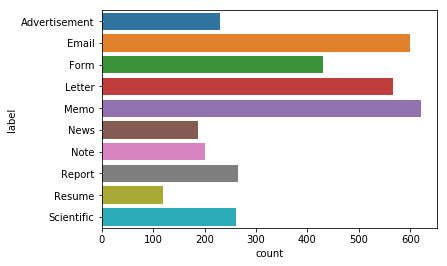

In [52]:
sns.countplot(data=data,y='label') 
plt.show()

On constate que pour des techniques de classification et de traitement automatique de texte, le nombre des données est faible, et qu'il y a seulement quatre étiquettes plus présentes que les autres

- J'ai aussi effectué une analyse descriptive qui va permettre d'étudier la distribution des classes

In [53]:
classes = pd.read_csv('Tobacco3482.csv', sep = ",")
classes.sample(10)

,img_path,label
1426,Letter/502393490+-3490.jpg,Letter
1334,Letter/50004413_50004414.jpg,Letter
1336,Letter/50006758.jpg,Letter
2927,Report/505830872+-0875.jpg,Report
3416,Scientific/50511224-1224.jpg,Scientific
2478,News/1003042513-b.jpg,News
910,Form/2030138503.jpg,Form
1015,Form/2063330045.jpg,Form
2901,Report/503958547_503958548.jpg,Report
1490,Letter/504789202_504789204.jpg,Letter


- J'ai aussi vérifier s'il y a des étiquettes manquantes, des incohérence entre la classe réelle du document et la classe notée 

In [54]:
print("Les étiquettes manquantes :", 1.0 - classes.shape[0] / classes.dropna().shape[0])
s = 0
for i in range(classes.shape[0]):
    s += classes["img_path"][i].split("/")[0] == classes["label"][i]
print("Les documents mal classé :", classes.shape[0] - s)

Les étiquettes manquantes : 0.0
Les documents mal classé : 0


On a la certitude qu'il n'y a aucun document mal classé, et qu'il n'y a aucune étiquette manquantes

- Pour avoir une idée des données qu'on vas manipuler j'ai visualisé un echentillont du fichier

In [55]:
data_txt=[]
data_txt=data

NB = data_txt.shape[0]
for i in range (NB):
    A = data_txt.get_value(i, 'img_path')
    data_txt.set_value(i, 'img_path', 'Tobacco3482-OCR/'+A)
    data_txt.set_value(i, 'img_path', data_txt.get_value(i, 'img_path').split('.jpg')[0]+'.txt')
    data_txt.set_value(i, 'img_path',open(data_txt.get_value(i, 'img_path'), "r",encoding="utf8").read())
data_txt.columns = ['text','label']
print(data_txt.head())

                                                text          label
0  A Mpertant as yar\nsesiye teaetered cabiieess....  Advertisement
1  TE che fitm\n\nm66400 7127\n\nKOOLS are the on...  Advertisement
2  so ARN Rr nr\n\nBWR Ga ||\n\nVending Operators...  Advertisement
3  MARCH 24,19 VO — 3. Tersrearep\n\n \n\n‘ yi il...  Advertisement
4  ~\n\nSpend a milder moment qs\nwith Raleigh.\n...  Advertisement


On peut visualiser ici les quatre premiers textes (une partie du texte), et l'étiquette associée a celui-ci

# 2-Machine learniing

j'ai choisie ici d'appliquer deux mèthodes de machine learning, et donc traiter le texte, pour essayer d'entrainer les classifieurs et essayer de prédire la classe d'un document.

### 2.1-Bag of Word

Pour appliquer la méthode de bag of word, les documents doivent être transformés en vecteurs. Pour cela j'ai transformer les documents en vecteurs et je les est encodés en sac de mots en utilisant la fonction CountVectorizer de Sklearn.

Avant ça j'ai dévisé les données en trois parties, données d'entrainement, données de test, et données de validation.

In [56]:
X_train, X_app, y_train, y_app = train_test_split(data['text'], data['label'], test_size=0.4)
X_test,X_dev,y_test,y_dev=train_test_split(X_app, y_app, test_size=0.5)

j'ai pris 60% des données comme données d'entrainement, et les 40% qui reste sont dévisés en deux pour servir de données de teste et de validation 

In [57]:
print('train data size=',X_train.shape[0],'X_test data size=',X_test.shape[0],'dev data size=',X_dev.shape[0])

train data size= 2089 X_test data size= 696 dev data size= 697


In [58]:
vectorizer = CountVectorizer(max_features=2000)
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
X_dev_counts = vectorizer.transform(X_dev)
X_test_counts = vectorizer.transform(X_test)    

- J'ai ensuite appliqué la fonction GridSearsh sur un classifieur bayésien naïf, pour trouver le meilleur paramètre alpha, avec une cross validation=5, la précision du classifieur est la moyenne des précision de chaque opération.
- Le principe de ce classifieur est d'utiliser une hypothèse d'indépendence entre les caractéristiques des classes pour estimer une probabilité associée à l'appartenance à une classe.

In [59]:
parameters = {'alpha' : [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0]}

nb_classifier = MultinomialNB()
grid_search_clf = GridSearchCV(nb_classifier, parameters, cv=5, return_train_score=True)
grid_search_clf.fit(X_train_counts, y_train)
res = grid_search_clf.cv_results_

for i in range(1,11):
    print('Rang', i)
    ind = np.where(res['rank_test_score'] == i)
    print('Alpha : {}'.format(res['params'][ind[0][0]]['alpha']))
    print('La précision moyenne : {}\n'.format(round(res['mean_test_score'][ind][0], 3)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Rang 1
Alpha : 1.0
La précision moyenne : 0.719

Rang 2
Alpha : 2.0
La précision moyenne : 0.715

Rang 3
Alpha : 3.0
La précision moyenne : 0.714

Rang 4
Alpha : 5.0
La précision moyenne : 0.708

Rang 5
Alpha : 4.0
La précision moyenne : 0.707

Rang 6
Alpha : 7.0
La précision moyenne : 0.691

Rang 7
Alpha : 8.0
La précision moyenne : 0.687

Rang 8
Alpha : 9.0
La précision moyenne : 0.682

Rang 9
Alpha : 10.0
La précision moyenne : 0.676

Rang 10
Alpha : 0.0
La précision moyenne : 0.651



Aprés dix valuers de alpha testés par GridSearch, on remparque que la valeur 1 donne la meilleur precision, je vais utiliser cette valeur donc pour construire un classifiur bayésien, l'entrainé et le testé sur les données de teste et de validation.

In [60]:
nb_classifier = MultinomialNB(alpha=1.)
nb_classifier.fit(X_train_counts, y_train)

pred_train = nb_classifier.predict(X_train_counts)
pred_dev = nb_classifier.predict(X_dev_counts)
pred_test = nb_classifier.predict(X_test_counts)

print("La précision sur les données d'entrainement est : ", metrics.accuracy_score(y_train, pred_train))
print("La précision sur les données de validation est : ", metrics.accuracy_score(y_dev, pred_dev))
print("La précision sur les données de test est : ", metrics.accuracy_score(y_test, pred_test))

La précision sur les données d'entrainement est :  0.8353279080899952
La précision sur les données de validation est :  0.7101865136298422
La précision sur les données de test est :  0.7140804597701149


### 2.2-TF IDF

In [61]:
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_dev_tf = tf_transformer.transform(X_dev_counts)
X_test_tf = tf_transformer.transform(X_test_counts)

De meme que pour la methode de bag of word, je vais utiliser, le classifieur bayésien, créé avec un alpha=1, pour calculer la precision sur chaque jeux de données.

In [62]:
nb_classifier.fit(X_train_tf, y_train)

pred_train_tf = nb_classifier.predict(X_train_tf)
pred_dev_tf = nb_classifier.predict(X_dev_tf)
pred_test_tf = nb_classifier.predict(X_test_tf)

print("La précision sur les données d'entrainement est: ", metrics.accuracy_score(y_train, pred_train_tf))
print("La précision sur les données de validation est : ", metrics.accuracy_score(y_dev, pred_dev_tf))
print("La précision sur les données de test est : ", metrics.accuracy_score(y_test, pred_test_tf))

La précision sur les données d'entrainement est:  0.7415031115366204
La précision sur les données de validation est :  0.6556671449067432
La précision sur les données de test est :  0.6422413793103449


# 3-Deep Learning

### - MLP with BoW

J'ai choisie dans cette partie d'implémenter un MLP ( multi layer perceptrant), avec les données issus de la methode bag of word, puisque c'est elle qui nous à donné de meilleur résultat de pecision, pour cela j'ai utilisé une couche d'activation 'relu', un alpha=1, un solveur de type 'verbose' et un batch size de taille 50, normalement c'est paramètre devrait etre calculé avec la fonction GridSearch, avec une cross validation mais par manque de ressources matériels, ça prend beaucoup de temps.

In [63]:
mlp_clf = MLPClassifier(activation='relu', alpha=1.0, verbose=2, batch_size=50)
mlp_clf.fit(X_train_counts, y_train)

pred_train_mlp = mlp_clf.predict(X_train_counts)
pred_dev_mlp = mlp_clf.predict(X_dev_counts)
pred_test_mlp = mlp_clf.predict(X_test_counts)

print("La précision sur les données d'entrainement est : ", metrics.accuracy_score(y_train, pred_train_mlp))
print("La précision sur les données de validation est : ", metrics.accuracy_score(y_dev, pred_dev_mlp))
print("La précision sur les données de test est : ", metrics.accuracy_score(y_test, pred_test_mlp))

Iteration 1, loss = 3.02131435
Iteration 2, loss = 1.64572152
Iteration 3, loss = 1.20849408
Iteration 4, loss = 1.00649682
Iteration 5, loss = 0.90467386
Iteration 6, loss = 0.83971021
Iteration 7, loss = 0.80657177
Iteration 8, loss = 0.78652692
Iteration 9, loss = 0.76760132
Iteration 10, loss = 0.74839446
Iteration 11, loss = 0.74797964
Iteration 12, loss = 0.73603652
Iteration 13, loss = 0.72608540
Iteration 14, loss = 0.72080346
Iteration 15, loss = 0.72336314
Iteration 16, loss = 0.72521637
Iteration 17, loss = 0.72841585
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
La précision sur les données d'entrainement est :  0.9621828626136908
La précision sur les données de validation est :  0.7790530846484935
La précision sur les données de test est :  0.7586206896551724


# 3-Analyse des Performances 

In [76]:
print('------------------  Naive Bayse Bag Of  Word  ------------------\n')
print("La précision sur les données d'entrainement est : ", metrics.accuracy_score(y_train, pred_train))
print("La précision sur les données de validation est : ", metrics.accuracy_score(y_dev, pred_dev))
print("La précision sur les données de test est : ", metrics.accuracy_score(y_test, pred_test))
print('\n\n Matrice de Classification \n')
print(classification_report(y_test, pred_test))
print('Matrice de Confusion Bag Of Word')
print(confusion_matrix(y_test, pred_test))

------------------  Naive Bayse Bag Of  Word  ------------------

La précision sur les données d'entrainement est :  0.8353279080899952
La précision sur les données de validation est :  0.7101865136298422
La précision sur les données de test est :  0.7140804597701149


 Matrice de Classification 

               precision    recall  f1-score   support

Advertisement       0.64      0.60      0.62        47
        Email       0.93      0.94      0.94       120
         Form       0.70      0.82      0.75        76
       Letter       0.74      0.61      0.67       132
         Memo       0.63      0.75      0.68       112
         News       0.62      0.79      0.70        38
         Note       0.44      0.28      0.34        39
       Report       0.51      0.54      0.53        48
       Resume       1.00      0.95      0.98        21
   Scientific       0.78      0.67      0.72        63

  avg / total       0.72      0.71      0.71       696

Matrice de Confusion Bag Of Word
[[ 28

In [75]:
print('---------------------- TF-IDF -----------------------\n')
print("La précision sur les données d'entrainement es: ", metrics.accuracy_score(y_train, pred_train_tf))
print("La précision sur les données de validation est : ", metrics.accuracy_score(y_dev, pred_dev_tf))
print("La précision sur les données de test est : ", metrics.accuracy_score(y_test, pred_test_tf))
print('\n\n Matrice de Classification \n')
print(classification_report(y_test, pred_test_tf))
print()
print('Matrice de Confusion TF-IDF')
print(confusion_matrix(y_test, pred_test_tf))

---------------------- TF-IDF -----------------------

La précision sur les données d'entrainement es:  0.7415031115366204
La précision sur les données de validation est :  0.6556671449067432
La précision sur les données de test est :  0.6422413793103449


 Matrice de Classification 

               precision    recall  f1-score   support

Advertisement       1.00      0.21      0.35        47
        Email       0.90      0.94      0.92       120
         Form       0.58      0.84      0.68        76
       Letter       0.56      0.67      0.61       132
         Memo       0.46      0.86      0.60       112
         News       0.91      0.53      0.67        38
         Note       0.00      0.00      0.00        39
       Report       0.56      0.10      0.18        48
       Resume       1.00      0.90      0.95        21
   Scientific       0.89      0.51      0.65        63

  avg / total       0.67      0.64      0.61       696


Matrice de Confusion TF-IDF
[[ 10   1  16   8  12 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
print('---------------------- MLP Classifier with TF-IDF representation -----------------------\n')

print("La précision sur les données d'entrainement est : ", metrics.accuracy_score(y_train, pred_train_mlp))
print("La précision sur les données de validation est : ", metrics.accuracy_score(y_dev, pred_dev_mlp))
print("La précision sur les données de test est : ", metrics.accuracy_score(y_test, pred_test_mlp))
print('\n\n Matrice de Classification \n')
print(classification_report(y_test, pred_test_mlp))
print()
print('Matrice de Confusion MLP-BoW')
print(confusion_matrix(y_test, pred_test_mlp))

---------------------- MLP Classifier with TF-IDF representation -----------------------

La précision sur les données d'entrainement est :  0.9621828626136908
La précision sur les données de validation est :  0.7790530846484935
La précision sur les données de test est :  0.7586206896551724


 Matrice de Classification 

               precision    recall  f1-score   support

Advertisement       0.80      0.43      0.56        47
        Email       0.92      0.97      0.94       120
         Form       0.72      0.89      0.80        76
       Letter       0.78      0.69      0.73       132
         Memo       0.76      0.82      0.79       112
         News       0.78      0.76      0.77        38
         Note       0.50      0.82      0.62        39
       Report       0.48      0.48      0.48        48
       Resume       1.00      0.95      0.98        21
   Scientific       0.84      0.59      0.69        63

  avg / total       0.77      0.76      0.76       696


Matrice de Co

# Conclusion 

Dans ce travail j'ai comparé entre deux methodes, la première cosistait à entrainer un classifieur bayésien naif, sur des données transformées par un Bag Of Word, et un TF-IDF, la deuxième methode consiste à utiliser un réseau de neurones dans mon cas un MLP, pour classer les meme donnnées. l'utilisation d'un classifieur bayesien,est  réputé pour etre non performant dans le cas où les mots son dépendant entre eux, mais puisque c'est simple à implémenter et rapide à exécuter j'ai choisie de le tester, et puis le comparer avec un reseau de neurone qui sont réputés pour etre beaucoup plus raubuste et voir ce que ça donne.

J'ai remarque que le modèle bayèsien nous donne une précision de 71% dans le cas où les données sont transformées avec un bag of word, et 64% dans le cas où il sont transformées avec un TF-IDF
Tandis qu'avec le reseau de neurones la précision sur les données de test est de 75%.
En regardant la matrice de Confusion des deux approches, on remarque que la méthode bayésiène n'est pas équilibré et de nombreuses classes sont confondus, contairement à la matrice du reseau de neurone.

# Pistes d'améliorations

l'idée que j'ai eu et que j'ai appliqué durant ce travail et de combiner les approches, mais on pourrait aller plus loin, puisque de nos jours les CNN, sont entrain d'ateindres des résultats trés satisfaisants,en terme de reconnaissance d'image, et puisque on à déjas les images des documents scanés, on aura pas besoin du texte obtenu à l'aide d'un OCR et qui contient des erreurs d'interprétation, on donne en entrée à un reseau de neurones à convolution, nos images de documents qui va classer automatiquement, seul inconvénient c'est qu'il faut avoir une grande base de données d'apprentissage étiquettée. 


